# Assignment 3.1

## Reading S3 bucket into SageMaker Studio

In [90]:
import boto3
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter

s3_client = boto3.client("s3")

BUCKET='ads508projectbucket'

# For Country_and_Subscriber_df
Country_and_Subscriber_Key='Aggregated_Metrics_By_Country_And_Subscriber_Status.csv'
Country_and_Subscriber_response = s3_client.get_object(Bucket=BUCKET, Key=Country_and_Subscriber_Key)
Country_and_Subscriber_df = pd.read_csv(Country_and_Subscriber_response.get("Body"))

# For Video_df
Video_Key='Aggregated_Metrics_By_Video.csv'
Video_response = s3_client.get_object(Bucket=BUCKET, Key=Video_Key)
Video_df = pd.read_csv(Video_response.get("Body"))

# For Comments_df
Comments_Key='All_Comments_Final.csv'
Comments_response = s3_client.get_object(Bucket=BUCKET, Key=Comments_Key)
Comments_df = pd.read_csv(Comments_response.get("Body"))

# For Performance_df
Performance_Key='Video_Performance_Over_Time.csv'
Performance_response = s3_client.get_object(Bucket=BUCKET, Key=Performance_Key)
Performance_df = pd.read_csv(Performance_response.get("Body"))

## Exploring Data

#### Country_and_Subscriber_df

In [91]:
Country_and_Subscriber_df.head()

,Video Title,External Video ID,Video Length,Thumbnail link,Country Code,Is Subscribed,Views,Video Likes Added,Video Dislikes Added,Video Likes Removed,User Subscriptions Added,User Subscriptions Removed,Average View Percentage,Average Watch Time,User Comments Added
0,🌶 Hot Topics in Tech: Data Science Explained #...,OtqQYqRNDGI,59,https://i.ytimg.com/vi/OtqQYqRNDGI/hqdefault.jpg,HK,True,23,1,0,0,2,0,0.671870,39.640348,0
1,🌶 Hot Topics in Tech: Data Science Explained #...,OtqQYqRNDGI,59,https://i.ytimg.com/vi/OtqQYqRNDGI/hqdefault.jpg,ME,True,3,0,0,0,0,0,0.498870,29.433333,0
2,🌶 Hot Topics in Tech: Data Science Explained #...,OtqQYqRNDGI,59,https://i.ytimg.com/vi/OtqQYqRNDGI/hqdefault.jpg,RW,True,2,0,0,0,0,0,0.681780,40.225000,0
3,🌶 Hot Topics in Tech: Data Science Explained #...,OtqQYqRNDGI,59,https://i.ytimg.com/vi/OtqQYqRNDGI/hqdefault.jpg,US,True,979,81,6,8,16,4,0.694854,40.996389,0
4,🌶 Hot Topics in Tech: Data Science Explained #...,OtqQYqRNDGI,59,https://i.ytimg.com/vi/OtqQYqRNDGI/hqdefault.jpg,DE,False,75,3,0,1,0,0,0.661515,39.029373,0


Already, we can see multiple variables that can be removed prior to building a model. 'Thumbnail link' can be removed, but we might want to include 'Video Title' to see if certain key phrases can increase video views. 'External Video ID' is present in each data frame, so this will be kept to join the data frames together in the future prior to modeling. Once this is accomplished, "External Video ID' will be removed to stop it from hindering model performance. 

In [92]:
Country_and_Subscriber_df.dtypes

Video Title                    object
External Video ID              object
Video Length                    int64
Thumbnail link                 object
Country Code                   object
Is Subscribed                    bool
Views                           int64
Video Likes Added               int64
Video Dislikes Added            int64
Video Likes Removed             int64
User Subscriptions Added        int64
User Subscriptions Removed      int64
Average View Percentage       float64
Average Watch Time            float64
User Comments Added             int64
dtype: object

Here are the data types of each feature. Most of the data types are int, with only 1 boolean and 2 floats. The most important string data type in our data set will either be 'Country Code' or 'Video Title' depending on if we can extract key words from the title or not.

<function matplotlib.pyplot.show(*args, **kw)>

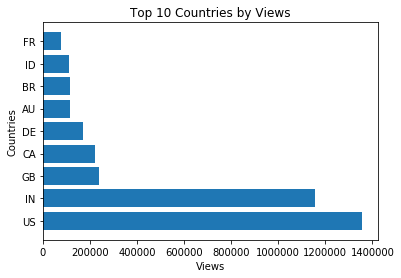

In [93]:
# Creating plot of views by country
grouped_country = Country_and_Subscriber_df.groupby(by = 'Country Code', as_index = False).sum()
grouped_country_sort = grouped_country.sort_values(by = 'Views', ascending = False)
xAxis = grouped_country_sort.loc[:,'Country Code'][:9]
yAxis = grouped_country_sort.loc[:,'Views'][:9]
plt.barh(xAxis, yAxis)
plt.title("Top 10 Countries by Views")
plt.xlabel('Views')
plt.ylabel('Countries')
plt.show

From this chart, we can see most of the data will come from these top 10 countries. This can introduce bias to our data set due to views mostly coming from a few countires (out of the 234 countires that view these videos). This will be an important aspect to consider going forward due to our model most likely giving insights that will reach American and Indian audiences more so than other countires. 

<function matplotlib.pyplot.show(*args, **kw)>

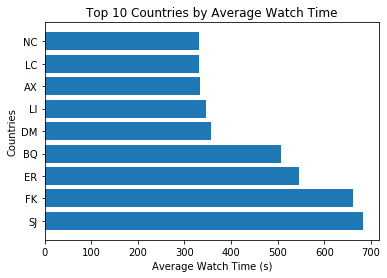

In [94]:
# Creating plot of average watch time by country
grouped_country = Country_and_Subscriber_df.groupby(by = 'Country Code', as_index = False).mean()
grouped_country_sort = grouped_country.sort_values(by = 'Average Watch Time', ascending = False)
xAxis = grouped_country_sort.loc[:,'Country Code'][:9]
yAxis = grouped_country_sort.loc[:,'Average Watch Time'][:9]
plt.barh(xAxis, yAxis)
plt.title("Top 10 Countries by Average Watch Time")
plt.xlabel('Average Watch Time (s)')
plt.ylabel('Countries')
plt.show

None of the countries with the most views appeared on this list, indicating that average watch time by country can be influenced by a smaller number of people watching. The less viewers in a country, the higher the variance.

In [95]:
# Making 'Video Title' into 1 long string to find the 10 most common words
data_set = ''.join(Country_and_Subscriber_df['Video Title'].unique().tolist())

# split() returns list of all the words in the string
split_it = data_set.split()

# Pass the split_it list to instance of Counter class.
Counters_found = Counter(split_it)
#print(Counters)

# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur = Counters_found.most_common(10)
print(most_occur)

[('Data', 154), ('Science', 116), ('-', 59), ('to', 39), ('a', 38), ('Your', 33), ('Projects', 27), ('in', 23), ('Episode', 23), ('for', 22)]


The 3 most common words that are not a dash, article, or pronoun are 'Data,' 'Science,' and 'Projects.' In the future, we can create boolean features of these words to indicate if they appear in the title or not and see how well they do at helping predict views and likes.

Text(0.5, 1.0, 'Comparison of Viewers')

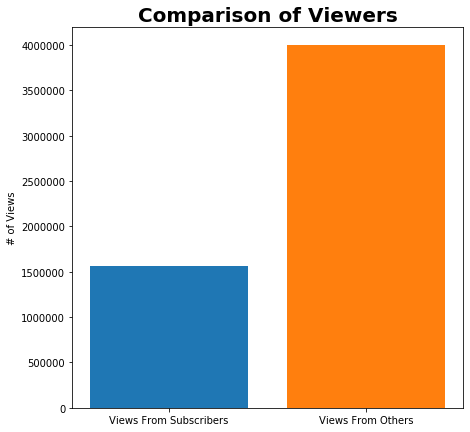

In [96]:
heads = {
    'weight': 'bold',
    'size' : 20,
}

view_subs = Country_and_Subscriber_df.loc[Country_and_Subscriber_df['Is Subscribed'] == True].drop('Is Subscribed', axis= 1)
view_not_subs = Country_and_Subscriber_df.loc[Country_and_Subscriber_df['Is Subscribed'] == False].drop('Is Subscribed', axis= 1)

plt.figure(figsize= (7, 7))
plt.bar('Views From Subscribers', view_subs['Views'].sum(), width= 0.8)
plt.bar('Views From Others', view_not_subs['Views'].sum(), width= 0.8)
plt.ylabel('# of Views')
plt.title('Comparison of Viewers', fontdict= heads)

This chart gives a breakdown of who currently watches this YouTubers videos. Information like this is helpful in seeing how he can better persuade his nonsubscriber audience to subscribe. Those who are not subscribed are more likely to not comment or like videos and are also less likely to see new videos he releases.

#### Video_df

In [97]:
Video_df.head()

,Video,Video title,Video pub­lish time,Com­ments ad­ded,Shares,Dis­likes,Likes,Sub­scribers lost,Sub­scribers gained,RPM (USD),CPM (USD),Av­er­age per­cent­age viewed (%),Av­er­age view dur­a­tion,Views,Watch time (hours),Sub­scribers,Your es­tim­ated rev­en­ue (USD),Im­pres­sions,Im­pres­sions click-through rate (%)
0,Total,NaN,NaN,14197,39640,3902,225021,45790,229241,5.276,11.990,26.61,0:03:25,5568487,317602.3536,183451,29068.652,100954064,3.16
1,4OZip0cgOho,How I Would Learn Data Science (If I Had to St...,"May 8, 2020",907,9583,942,46903,451,46904,6.353,12.835,36.65,0:03:09,1253559,65850.7042,46453,7959.533,26498799,3.14
2,78LjdAAw0wA,100K Channel Update + AMA Stream!,"Nov 12, 2020",412,4,4,130,15,12,2.668,6.259,6.26,0:05:14,2291,200.2966,-3,6.113,188318,0.72
3,hO_YKK_0Qck,Uber Driver to Machine Learning Engineer in 9 ...,"Jul 16, 2020",402,152,15,881,9,198,9.516,11.695,15.12,0:10:21,21350,3687.3387,189,202.963,442334,2.53
4,uXLnbdHMf8w,Why I'm Starting Data Science Over Again.,"Aug 29, 2020",375,367,22,2622,40,1957,3.143,7.943,33.41,0:02:36,49564,2148.3110,1917,155.779,521185,4.01


From looking at these features, there are good amount that will need to be removed prior to model building. For example, features having to do with revenue will not be included due to not having this knowledge prior to making a video. We are interested in either predicting the likes a video will receive or views, and revenue columns would have a high correlation with those metrics. However, we can analyze which videos bring in the highest monetary value to learn more about our data.

In [98]:
Video_df.dtypes

Video                                    object
Video title                              object
Video pub­lish time                      object
Com­ments ad­ded                          int64
Shares                                    int64
Dis­likes                                 int64
Likes                                     int64
Sub­scribers lost                         int64
Sub­scribers gained                       int64
RPM (USD)                               float64
CPM (USD)                               float64
Av­er­age per­cent­age viewed (%)       float64
Av­er­age view dur­a­tion                object
Views                                     int64
Watch time (hours)                      float64
Sub­scribers                              int64
Your es­tim­ated rev­en­ue (USD)        float64
Im­pres­sions                             int64
Im­pres­sions click-through rate (%)    float64
dtype: object

Other than our unique video ID, video title, and video publish date, the rest of the features are either type int or float. Average view duration is in minute format, so this should be changed to seconds in the future to stay consistent with our last data frame we explored.

<function matplotlib.pyplot.show(*args, **kw)>

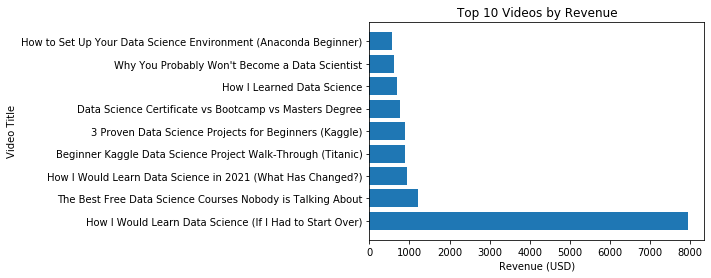

In [99]:
# Finding Videos with highest revenue
grouped_video = Video_df.groupby(by = 'Video title', as_index = False).sum()
grouped_video_sort = grouped_video.sort_values(by = str(Video_df.columns[16]), ascending = False)
xAxis = grouped_video_sort.loc[:,'Video title'][:9]
yAxis = grouped_video_sort.loc[:,str(Video_df.columns[16])][:9]
plt.barh(xAxis, yAxis)
plt.title("Top 10 Videos by Revenue")
plt.xlabel('Revenue (USD)')
plt.ylabel('Video Title')
plt.show

In [100]:
grouped_video.columns[3]

'Dis\xadlikes'

We can see that one video, 'How I Would Learn Data Science...'  outperformed the rest by a large margin. All the top performing videos contain 'Data Science' in the title. Instead of having individual columns for 'Data,' 'Science,' and 'Project,' we can have a boolean column that asks if 'Data Science' appears in the title.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<function matplotlib.pyplot.show(*args, **kw)>

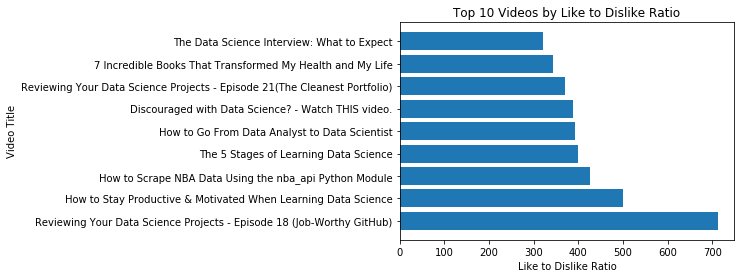

In [101]:
# Finding Like to Dislike ratio and ranking vidoes
test = grouped_video
test = test[test[test.columns[3]] > 0]
test['like_dislike_ratio'] = test['Likes'] / test[test.columns[3]]
test_sort = test.sort_values(by = 'like_dislike_ratio', ascending = False)
xAxis = test_sort.loc[:,'Video title'][:9]
yAxis = test_sort.loc[:,'like_dislike_ratio'][:9]
plt.barh(xAxis, yAxis)
plt.title("Top 10 Videos by Like to Dislike Ratio")
plt.xlabel('Like to Dislike Ratio')
plt.ylabel('Video Title')
plt.show

This chart shows which of his videos received the most positive reviews. This information is beneficial to all video creators looking to replicate their past success.

#### Comments_df

In [102]:
Comments_df.head()

,Comments,Comment_ID,Reply_Count,Like_Count,Date,VidId,user_ID
0,Thanks for this video Ken.\n\nI decided to go ...,UgxFZTIzC4UPyhhX_PZ4AaABAg,0,0,2022-01-22T08:13:29Z,xpIFS6jZbe8,user_981
1,Hello ken jee!!! I'm doing a graduation on Com...,Ugx3IYuAufhb932GYQx4AaABAg,0,0,2022-01-22T01:09:46Z,xpIFS6jZbe8,user_213
2,"Thanks for this video, man. So useful. I'll me...",UgyhwwoK24arzRt1mud4AaABAg,0,0,2022-01-21T23:59:05Z,rEWPqw6rMGI,user_1065
3,Great video!!! I started learning Python 8 mon...,UgwrrI7nd3WClsotmHV4AaABAg,0,0,2022-01-21T23:00:37Z,xpIFS6jZbe8,user_3391
4,Been watching hours of your material (and Tina...,UgxlOrHO4MHKSwY9mUN4AaABAg,0,0,2022-01-21T20:24:20Z,sHRq-LshG3U,user_2816


This data frame has the least number of columns we have encountered so far. From this data, we can try and examine key phrases in users’ comments and see how many likes they received. Sadly, we do not have information on if a user who left a comment also left a like or dislike, so there would not be a way to try and detect a positive or negative review by a comment alone.

In [103]:
Comments_df.dtypes

Comments       object
Comment_ID     object
Reply_Count     int64
Like_Count      int64
Date           object
VidId          object
user_ID        object
dtype: object

This data frame is string heavy, so we might want to make a column indicating which videos get the highest count of comments (most interaction).

<function matplotlib.pyplot.show(*args, **kw)>

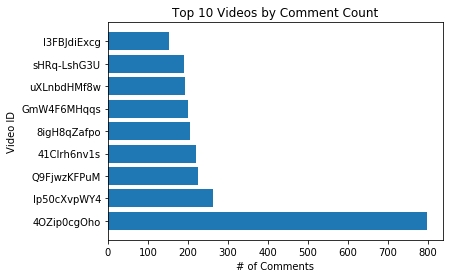

In [104]:
# Finding Comments with the most likes
grouped_comments = Comments_df.groupby(by = 'VidId', as_index = False).count()
grouped_comments_sort = grouped_comments.sort_values(by = 'Comments', ascending = False)
xAxis = grouped_comments_sort.loc[:,'Comments'][:9]
yAxis = grouped_comments_sort.loc[:,'VidId'][:9]
plt.barh(yAxis, xAxis)
plt.title("Top 10 Videos by Comment Count")
plt.xlabel('# of Comments')
plt.ylabel('Video ID')
plt.show

For this data to be clearer, we would need to find the video titles associated with those IDs. For now, it is a good starting point to see how many comments some of his videos received. As mentioned, we will make a new column in our future joined data frame which shows how many columns a video received.

#### Performance_df

In [105]:
Performance_df.head()

,Date,Video Title,External Video ID,Video Length,Thumbnail link,Views,Video Likes Added,Video Dislikes Added,Video Likes Removed,User Subscriptions Added,User Subscriptions Removed,Average View Percentage,Average Watch Time,User Comments Added
0,19 Jan 2022,Kaggle Project From Scratch - Part 2 (Explorat...,KQ80oD_boBM,2191,https://i.ytimg.com/vi/KQ80oD_boBM/hqdefault.jpg,13,0,0,0,0,0,0.069055,151.300154,0
1,19 Jan 2022,Welcome To My Channel | Ken Jee | Data Science,smeFkHwnM_k,51,https://i.ytimg.com/vi/smeFkHwnM_k/hqdefault.jpg,2,0,0,0,1,0,0.471255,24.034000,0
2,19 Jan 2022,How She Dominated the FAANG Data Science Inter...,vfV4nm004VQ,2686,https://i.ytimg.com/vi/vfV4nm004VQ/hqdefault.jpg,10,0,0,0,0,0,0.126049,338.567500,0
3,19 Jan 2022,The 9 Books That Changed My Perspective in 2019,3TrAYmrmA8o,980,https://i.ytimg.com/vi/3TrAYmrmA8o/hqdefault.jpg,1,0,0,0,0,0,0.011508,11.278000,0
4,19 Jan 2022,Interview with the Director of AI Research @ N...,Xgg7dIKys9E,2904,https://i.ytimg.com/vi/Xgg7dIKys9E/hqdefault.jpg,1,0,0,0,0,0,0.007541,21.900000,0


This data frame goes off daily performance of videos. This data set is ideal for time series analysis to see how number of views or subscriber count grows by the day.

In [106]:
Performance_df.dtypes

Date                           object
Video Title                    object
External Video ID              object
Video Length                    int64
Thumbnail link                 object
Views                           int64
Video Likes Added               int64
Video Dislikes Added            int64
Video Likes Removed             int64
User Subscriptions Added        int64
User Subscriptions Removed      int64
Average View Percentage       float64
Average Watch Time            float64
User Comments Added             int64
dtype: object

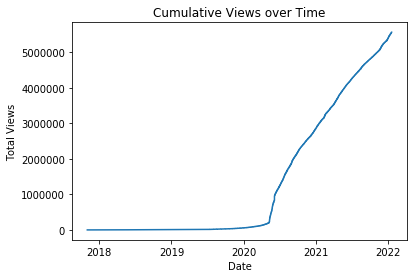

In [107]:
# Finding views gained over time
test = Performance_df
test['Date'] = pd.to_datetime(test['Date'])
test_sort = test.sort_values(by = 'Date', ascending = True)
xAxis = test_sort['Date']
yAxis = test_sort['Views'].cumsum()
ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
plt.plot(xAxis, yAxis)
plt.title('Cumulative Views over Time')
plt.xlabel('Date')
plt.ylabel('Total Views')
plt.show()

This chart really shows how much this YouTubers channel blew up in 2020. This is an important factor in seeing what changed this year compared to previous years. The pandemic could have had an influence in his growth.

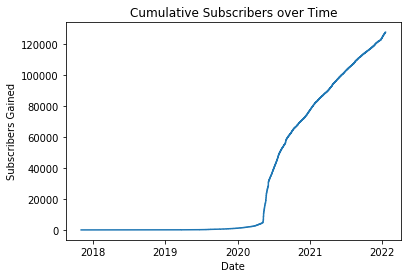

In [108]:
# Finding Subscriber Growth over time
lost = test_sort['User Subscriptions Removed'].cumsum()
gained = test_sort['User Subscriptions Added'].cumsum()
yAxis = gained - lost
ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
plt.plot(xAxis, yAxis)
plt.title('Cumulative Subscribers over Time')
plt.xlabel('Date')
plt.ylabel('Subscribers Gained')
plt.show()

This chart has a similar shape to the one we see above, which is logical. There will be more important data to be seen with dates after 2020, so it might be a good idea to filter out videos that were made prior. This way, we can reduce the noise in our future data set.